Names: Lyndia & Eashaankar


**Dataset description:**

3 seconds per clip, 25 clips per lass, 5 classes that are: Cat meow, ⁠dog bark, ⁠⁠boiling water, door knock, ⁠⁠background noise, baby/child cry

# Step 1: 数据加载 Upload dataset

这个模块负责将原始音频文件转换为模型可以接受的输入特征。

In [14]:
import os
# Load dataset from Google Drive
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset_Audios"

# Check if the folder exists
if os.path.exists(dataset_path):
    print(f"Dataset found at: {dataset_path}")
    print("Subfolders (classes):", os.listdir(dataset_path))
else:
    print("Dataset path not found. Please check your Google Drive path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found at: /content/drive/MyDrive/Dataset_Audios
Subfolders (classes): ['door_knock', 'boiling_water', 'baby_cry', 'cat_meow', 'background', 'dog_bark']


In [15]:
####    加载数据和标签    #####

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 您的数据集主目录 (请根据您上传数据的位置修改)
DATA_DIR = dataset_path
# 假设您的 6 个类别名称
CLASS_NAMES = ['baby_cry', 'boiling_water', 'door_knock', 'cat_meow', 'background', 'dog_bark']
NUM_CLASSES = len(CLASS_NAMES)
# 类别名称 -> 索引的映射
CLASS_TO_IDX = {name: i for i, name in enumerate(CLASS_NAMES)}

def get_file_list_and_labels(data_dir, class_to_idx):
    """遍历目录，收集文件路径和标签索引"""
    X = [] # 文件路径
    y = [] # 标签索引 (0-5)

    for class_name, class_idx in class_to_idx.items():
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(('.wav', '.flac', '.mp3')):
                    file_path = os.path.join(class_dir, filename)
                    X.append(file_path)
                    y.append(class_idx)
        else:
            print(f"Warning: Class directory not found or not a directory: {class_dir}")

    # 将列表转换为 NumPy 数组
    X = np.array(X)
    # 将整数标签转换为独热编码 (One-Hot Encoding)
    Y = to_categorical(y, num_classes=NUM_CLASSES)

    return X, Y

# 执行数据加载
X_files, Y_labels = get_file_list_and_labels(DATA_DIR, CLASS_TO_IDX)

# 拆分训练集和验证集 (80/20 分割)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_files, Y_labels, test_size=0.2, random_state=42, stratify=Y_labels
)

print(f"总文件数: {len(X_files)}")
print(f"训练集文件数: {len(X_train)}")
print(f"验证集文件数: {len(X_val)}")

总文件数: 126
训练集文件数: 100
验证集文件数: 26


# Step 2: 准备 VGgish 数据处理依赖 Preparing the $\text{VGgish}$ Data Processing Dependencies

由于数据集规模较小，我们将使用 $\text{Keras Sequence}$（或自定义生成器）来高效地加载和提取音频特征，以优化内存管理。本步骤将克隆 TensorFlow $\text{VGgish}$ 源代码库并将其路径添加到系统环境变量，确保后续的特征提取工具可用。

Given the limited size of our dataset, we will use a $\text{Keras Sequence}$ (or a custom generator) to efficiently load and extract audio features, thereby optimizing memory usage. This step clones the TensorFlow $\text{VGgish}$ source code repository and adds its path to the system environment to ensure the necessary feature extraction tools are accessible for the subsequent steps.

In [16]:
import os
import sys

# Clone the VGGish repository if it doesn't exist
vggish_repo_path = '/content/models'
# The VGGish source code is nested within the models repository
vggish_src_path = os.path.join(vggish_repo_path, 'research', 'audioset', 'vggish')

if not os.path.exists(vggish_src_path):
    print(f"Cloning TensorFlow models repository to {vggish_repo_path}...")
    !git clone https://github.com/tensorflow/models.git {vggish_repo_path}
    print(f"VGGish source path: {vggish_src_path}")
else:
    print(f"TensorFlow models repository already exists at {vggish_repo_path}.")
    print(f"VGGish source path: {vggish_src_path}")

# Add the VGGish source path to Python's system path
if vggish_src_path not in sys.path:
    sys.path.insert(0, vggish_src_path)
    print(f"Added {vggish_src_path} to sys.path.")
else:
    print(f"{vggish_src_path} is already in sys.path.")


TensorFlow models repository already exists at /content/models.
VGGish source path: /content/models/research/audioset/vggish
/content/models/research/audioset/vggish is already in sys.path.


# Step 3: 加载 $\text{VGgish}$ 特征提取模型 Loading the $\text{VGgish}$ Feature Extraction Model

在进入主训练循环之前，我们首先需要准备特征提取器。本步骤会安装 $\text{resampy}$ 等必要的依赖项，并从 $\text{TensorFlow Hub}$ 加载预训练的 $\text{VGgish}$ 模型。该模型将音频输入转换为 $\text{128}$ 维的嵌入（Embedding），作为我们 $\text{CNN}$ 模型的输入特征。

Prior to initiating the main training loop, we must first prepare the feature extractor. This step installs necessary dependencies like $\text{resampy}$ and loads the pre-trained $\text{VGgish}$ model from $\text{TensorFlow Hub}$. This model converts the audio input into a $\text{128}$-dimensional embedding, which will serve as the input features for our $\text{CNN}$ model.

In [17]:
### ebf5c17a
import tensorflow as tf
import os
import tensorflow_hub as hub # 新增：导入 tensorflow_hub

# 确保 resampy 依赖项已安装
!pip install resampy

# VGGish 的参数（例如采样率）仍然需要，因此我们保留这个导入
import vggish_params

# EMBEDDING_SIZE 是 VGGish 的已知常量
EMBEDDING_SIZE = 128

# 定义 TF Hub VGGish 模型的 URL
VGGISH_MODEL_URL = 'https://tfhub.dev/google/vggish/1'

# 从 TF Hub 加载 VGGish 模型
def load_vggish_model_from_hub():
    print(f"Loading VGGish model from TensorFlow Hub: {VGGISH_MODEL_URL}")
    # TF Hub 的 VGGish 模块是一个可调用对象，直接接受原始音频并返回嵌入
    vggish_model = hub.load(VGGISH_MODEL_URL)
    return vggish_model

GLOBAL_VGGISH_MODEL = load_vggish_model_from_hub()
print("VGGish model loaded successfully from TensorFlow Hub.")

# VGGish 的输出是 128 维的嵌入
NEW_INPUT_SHAPE = (EMBEDDING_SIZE,)
print(f"新的模型输入形状将是: {NEW_INPUT_SHAPE} (VGGish 嵌入维度)")

Loading VGGish model from TensorFlow Hub: https://tfhub.dev/google/vggish/1
VGGish model loaded successfully from TensorFlow Hub.
新的模型输入形状将是: (128,) (VGGish 嵌入维度)


# Step 4: 定义特征提取函数 Defining the Feature Extraction Function (load_and_extract_feature)

本步骤定义了核心函数 $\text{load\_and\_extract\_feature}$，该函数使用 $\text{librosa}$ 库加载音频文件并重采样到 $\text{16kHz}$。随后，它利用 $\text{TensorFlow Hub}$ 加载的 $\text{VGgish}$ 模型将音频波形转换为 $\text{128}$ 维的嵌入向量。对于包含多个嵌入的音频文件，函数会计算其平均值，最终为整个音频返回一个单一的特征向量。

This step defines the core function $\text{load\_and\_extract\_feature}$, which uses the $\text{librosa}$ library to load audio files and resample them to $\text{16kHz}$. Subsequently, it utilizes the $\text{VGgish}$ model (loaded from $\text{TensorFlow Hub}$) to convert the raw audio waveform into $\text{128}$-dimensional embedding vectors. For files generating multiple embeddings, the function computes their mean to return a single feature vector for the entire audio clip.

In [18]:
##d3d54625
import librosa
import numpy as np
# 移除：不再需要 vggish_input.waveform_to_examples，因为 TF Hub 模型直接处理原始音频
# 仍然需要 vggish_params 来获取采样率
import vggish_params

# 更新特征提取函数以使用 VGGish (从 TF Hub 加载的模型)
def load_and_extract_feature(file_path):
    """加载音频并使用 VGGish (TF Hub) 提取嵌入特征。"""
    try:
        # 1. 加载和重采样音频到 16kHz
        # VGGish TF Hub 模块期望原始音频波形为 16kHz, 单声道, float32 NumPy 数组
        audio, sr = librosa.load(file_path, sr=vggish_params.SAMPLE_RATE, mono=True)

        # 2. 使用 VGGish TF Hub 模型提取嵌入
        # hub.load 模型直接接受原始音频波形
        # 它返回一个 EagerTensor，我们需要将其转换为 NumPy 数组
        embeddings = GLOBAL_VGGISH_MODEL(audio).numpy()

        # VGGish 会为每个 0.96 秒的帧生成一个 128 维的嵌入。
        # 我们需要聚合这些嵌入，例如取平均值，得到整个音频片段的单一嵌入向量。
        if embeddings.shape[0] > 0:
            # 对所有帧的嵌入取平均值
            mean_embedding = np.mean(embeddings, axis=0)
            return mean_embedding
        else:
            print(f"Warning: No embeddings generated for {file_path}. Returning zeros.")
            return np.zeros(NEW_INPUT_SHAPE) # 返回一个零向量作为占位符

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# 估算模型输入形状 (现在由 VGGish 嵌入决定)
INPUT_SHAPE = NEW_INPUT_SHAPE

print(f"模型的输入形状现在是 (VGGish 嵌入维度): {INPUT_SHAPE}")

模型的输入形状现在是 (VGGish 嵌入维度): (128,)


# Step 4.5: 音频到图像的可视化 Audio to Image Visualization

为了更好地理解 VGGish 模型如何处理音频，我们将随机选择一个音频文件，并将其转换为对数梅尔谱图（log Mel-spectrogram），这是 VGGish 内部处理音频波形的一个重要中间步骤。梅尔谱图能够以视觉方式表示音频的频率内容随时间的变化，类似于图像，VGGish 会基于此提取128维的特征。

To better understand how the VGGish model processes audio, we will randomly select an audio file and convert it into a log Mel-spectrogram. This is a crucial intermediate step in VGGish's internal processing of audio waveforms. A Mel-spectrogram visually represents the frequency content of audio over time, similar to an image, and VGGish extracts 128-dimensional features based on this representation.

Selected random audio file for visualization: /content/drive/MyDrive/Dataset_Audios/boiling_water/Boiling13.wav


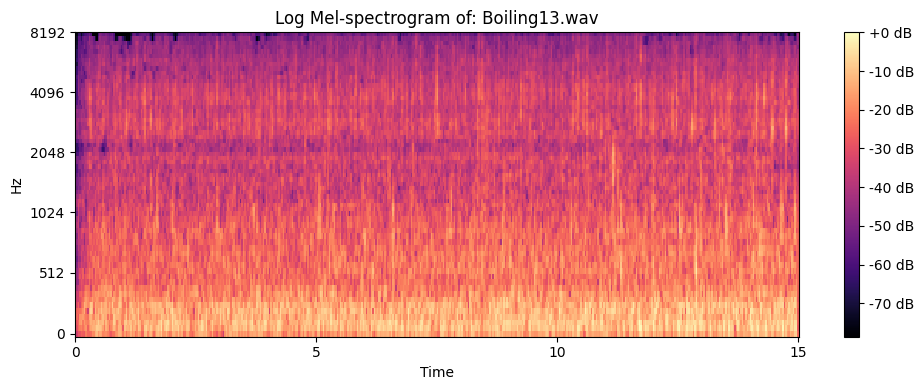


This plot shows the frequency content (y-axis, in Mel scale) over time (x-axis) for the audio file.
Brighter colors indicate higher energy at that frequency and time. VGGish processes such spectrograms to extract features.


In [19]:
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Get a random file path from the training set for demonstration
random_file_path = random.choice(X_train)
print(f"Selected random audio file for visualization: {random_file_path}")

# Load the audio file and resample to VGGish's expected sample rate (16kHz)
# VGGish expects 16kHz, mono audio.
audio, sr = librosa.load(random_file_path, sr=vggish_params.SAMPLE_RATE, mono=True)

# Generate Mel-spectrogram (VGGish uses log Mel-spectrograms)
# The VGGish model handles the specific parameters for Mel-spectrogram creation internally,
# but we can simulate a similar visualization.
# Using VGGish's parameters for consistency
# For VGGish, frame_length = 0.025 seconds, frame_step = 0.010 seconds
# n_fft = int(sr * 0.025) = 16000 * 0.025 = 400
# hop_length = int(sr * 0.010) = 16000 * 0.010 = 160

# Let's use librosa defaults or close to VGGish parameters for a visual example
# librosa.feature.melspectrogram is a good approximation.
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=400, hop_length=160, n_mels=64)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Log Mel-spectrogram of: {os.path.basename(random_file_path)}')
plt.tight_layout()
plt.show()

print("\nThis plot shows the frequency content (y-axis, in Mel scale) over time (x-axis) for the audio file.\nBrighter colors indicate higher energy at that frequency and time. VGGish processes such spectrograms to extract features.")


# Step 5：定义Keras数据生成器 Defining the Keras Data Generator: DataGenerator

为了高效处理数据集并避免内存问题，本步骤定义了一个继承自 $\text{Keras.utils.Sequence}$ 的 $\text{DataGenerator}$ 类。该生成器负责在每个训练 $\text{epoch}$ 中以小批次 ($\text{batch}$) 形式加载文件路径和标签，并在后台调用 load_and_extract_feature()函数进行实时特征提取，从而实现对训练数据的异步和批量处理。

To efficiently handle the dataset and prevent memory overflow issues, this step defines the $\text{DataGenerator}$ class, which inherits from $\text{Keras.utils.Sequence}$. This generator is responsible for loading file paths and labels in small batches during each training epoch, asynchronously calling the load_and_extract_feature() function to perform real-time feature extraction, enabling asynchronous and batch processing of the training data.

In [20]:
## dXPd9A_bF6E0 定义 DataGenerator 类

from tensorflow.keras.utils import Sequence
import numpy as np # 确保 numpy 被导入

class DataGenerator(Sequence):
    """用于 Keras fit() 函数的数据生成器，实时加载和预处理数据"""
    def __init__(self, file_paths, labels, batch_size=32, shuffle=True, input_shape=None):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape # 新增：接收 input_shape
        if self.input_shape is None:
            raise ValueError("DataGenerator must be initialized with an input_shape.")
        self.on_epoch_end()

    def __len__(self):
        """返回每个 epoch 的批次总数"""
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        """生成一个批次的数据"""
        # 索引列表，用于获取当前批次的特征和标签
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # 根据索引获取文件路径和标签
        list_files_temp = [self.file_paths[k] for k in indices]
        list_labels_temp = [self.labels[k] for k in indices]

        # 生成数据 (X: 特征, y: 标签)
        X, y = self.__data_generation(list_files_temp, list_labels_temp)
        return X, y

    def on_epoch_end(self):
        """在每个 epoch 结束后更新索引 (如果需要打乱) """
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, list_files, list_labels):
        """将文件路径转换为特征矩阵"""
        # 初始化批次特征矩阵 (现在使用 self.input_shape)
        X = np.empty((self.batch_size, *self.input_shape))
        y = np.empty((self.batch_size, NUM_CLASSES), dtype=int)

        for i, file_path in enumerate(list_files):
            # 调用特征提取函数
            feature = load_and_extract_feature(file_path)

            # 如果特征提取失败，返回一个零向量
            if feature is None or feature.shape != self.input_shape:
                print(f"Warning: Feature for {file_path} is None or has wrong shape {feature.shape if feature is not None else 'None'}, expected {self.input_shape}. Returning zeros.")
                feature = np.zeros(self.input_shape)

            X[i,] = feature
            y[i] = list_labels[i]

        return X, y

# Step 6:构建与编译Dense层分类器 Building and Compiling the $\text{Dense}$ Layer Classifier

This step defines a classifier based on the $\text{Keras Sequential}$ model, which takes the $\text{128}$-dimensional $\text{VGgish}$ embeddings as its input. The model includes multiple $\text{Dense}$ (fully connected) layers combined with $\text{Dropout}$ regularization for classifying the audio features. Finally, the model is compiled using the $\text{Adam}$ optimizer and the $\text{categorical\_crossentropy}$ loss function.

In [21]:
## e06d233d 定义分类器模型

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf # 确保 tf 已导入

def create_classifier_model():
    # 清除会话，确保模型从一个干净的状态开始构建
    tf.keras.backend.clear_session()

    model = Sequential([
        # VGGish 嵌入是 128 维，直接作为 Dense 层的输入
        Dense(256, activation='relu', input_shape=INPUT_SHAPE),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 实例化新的分类器模型
model = create_classifier_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,694 (260.52 KB)

 Trainable params: 66,694 (260.52 KB)

 Non-trainable params: 0 (0.00 B)

# Step 7 配置与执行模型训练 Configuring and Executing Model Training

本步骤重新实例化分类器模型，并创建新的数据生成器实例，以确保使用正确的输入形状和批次大小。接着，配置了 $\text{ModelCheckpoint}$（用于保存最佳模型）和 $\text{EarlyStopping}$（用于防止过拟合）两个回调函数。最后，使用配置好的生成器和回调函数，启动模型在训练数据集上的拟合过程，并在完成后保存最终模型。

This step re-instantiates the classifier model and creates new data generator instances to ensure the correct input shape and batch sizes are used. Subsequently, it configures two essential callbacks: $\text{ModelCheckpoint}$ (to save the best model) and $\text{EarlyStopping}$ (to prevent overfitting). Finally, the model fitting process is initiated using the configured generators and callbacks, and the final model is saved upon completion.

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Re-instantiate the model to ensure it uses the latest INPUT_SHAPE
model = create_classifier_model()
print("Re-created VGGish-compatible classifier model.")
model.summary()

# Re-create DataGenerator instances to ensure they pick up the updated INPUT_SHAPE and load_and_extract_feature
BATCH_SIZE = 10 # 您的数据集小，使用较小的批次
train_generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True, input_shape=INPUT_SHAPE)

# For validation, use a batch size that is less than or equal to the total number of validation samples
# or set to len(X_val) to ensure at least one batch is created.
validation_batch_size = min(BATCH_SIZE, len(X_val)) if len(X_val) > 0 else 1
validation_generator = DataGenerator(X_val, Y_val, batch_size=validation_batch_size, shuffle=False, input_shape=INPUT_SHAPE)

print(f"Re-created DataGenerators with batch size: {BATCH_SIZE} (train), {validation_batch_size} (val) and expected feature shape: {INPUT_SHAPE}")

# 设置回调函数，用于保存最佳模型和早停
checkpoint_filepath = 'best_audio_model.keras' # Colab 推荐使用 .keras 格式
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # 保存整个模型
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("\n--- 开始训练循环 ---")

# # 训练模型
history = model.fit(
     train_generator,
     validation_data=validation_generator,
     epochs=50, # 可以尝试更多的 epoch
     callbacks=[model_checkpoint_callback, early_stopping_callback],
     verbose=1
 )

model.save("final_audio_model.keras")
print("--- 模型骨架搭建完成 ---")

Re-created VGGish-compatible classifier model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,694 (260.52 KB)

 Trainable params: 66,694 (260.52 KB)

 Non-trainable params: 0 (0.00 B)

Re-created DataGenerators with batch size: 10 (train), 10 (val) and expected feature shape: (128,)

--- 开始训练循环 ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 565ms/step - accuracy: 0.1559 - loss: 1.8550 - val_accuracy: 0.7000 - val_loss: 1.4586
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.3895 - loss: 1.4816 - val_accuracy: 0.9000 - val_loss: 1.1956
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5351 - loss: 1.2257 - val_accuracy: 0.8500 - val_loss: 0.9643
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.6604 - loss: 0.9912 - val_accuracy: 0.8500 - val_loss: 0.7668
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.7728 - loss: 0.7316 - val_accuracy: 0.9500 - val_loss: 0.5735
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8534 - loss: 0.7170 - val_accuracy: 0.9500 - val_loss: 0.4362
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8553 - loss: 0.6091 - val_accuracy: 0.9500 - val_loss: 0.3468
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8734 - loss: 0.4814 - val_accuracy: 0

# Step 8：评估模型性能与可视化训练结果 Evaluating Model Performance and Visualizing Training Results

本步骤首先定义了 $\text{plot\_curves}$ 函数，用于将训练历史中的准确率和损失（包括训练集和验证集）绘制成图表，以直观地分析模型的收敛和过拟合情况。随后，模型在验证数据集上进行最终评估，并打印出最终的验证准确率和损失值，以总结模型的性能。

This step first defines the $\text{plot\_curves}$ function, which visualizes the training history (accuracy and loss for both training and validation sets) to intuitively analyze the model's convergence and potential overfitting. Subsequently, the model undergoes a final evaluation on the validation dataset, printing the final validation accuracy and loss to summarize the overall model performance.

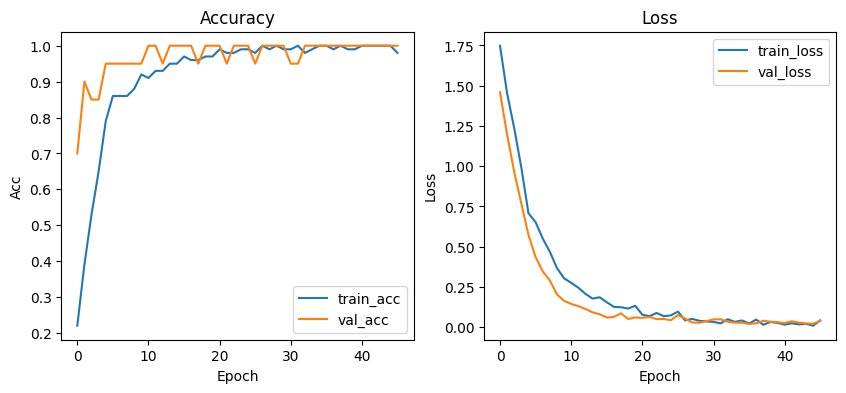

[Model] Val Acc: 1.0000 | Val Loss: 0.0212


In [23]:
# for visualization
import matplotlib.pyplot as plt

# print (1)Model #1
def plot_curves(h):
    plt.figure(figsize=(10,4))
    # acc
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()
    # loss
    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.show()

plot_curves(history)

# ---- evaluate and print----
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
print(f"[Model] Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

# Step 9：Exporting Keras

In [25]:
from google.colab import drive
import os

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Choose a folder in Drive to store your models
MODEL_DIR = "/content/drive/MyDrive/AudioModels"  # change the folder name if you like
os.makedirs(MODEL_DIR, exist_ok=True)

# 3. Save models directly into that folder
final_model_path = os.path.join(MODEL_DIR, "final_audio_model.keras")
best_model_path  = os.path.join(MODEL_DIR, "best_audio_model.keras")

# Assuming 'model' is your trained classifier
model.save(final_model_path)
print(f"final_audio_model.keras saved to: {final_model_path}")

# If you also want to copy the best model (saved by ModelCheckpoint)
if os.path.exists("best_audio_model.keras"):
    import shutil
    shutil.copy("best_audio_model.keras", best_model_path)
    print(f"best_audio_model.keras copied to: {best_model_path}")
else:
    print("Warning: best_audio_model.keras not found in /content")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
final_audio_model.keras saved to: /content/drive/MyDrive/AudioModels/final_audio_model.keras
best_audio_model.keras copied to: /content/drive/MyDrive/AudioModels/best_audio_model.keras
